In [1]:
!pip install https://github.com/mlc-ai/package/releases/download/v0.9.dev0/mlc_ai_nightly_cu121-0.12.dev1880-cp310-cp310-manylinux_2_28_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.2/569.2 MB 1.1 MB/s eta 0:00:0000:0100:13
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 KB 2.0 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 1.2 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 KB 819.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 KB 826.3 kB/s eta 0:00:0000:0100:01


In [3]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 1.2 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 KB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.2 MB/s eta 0:00:00a 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 KB 1.1 MB/s eta 0:00:00a 0:00:01


In [4]:
import time
import IPython
import numpy as np
from matplotlib import pyplot, cm
import matplotlib.pyplot as plt
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [5]:
meshscale = 6
nx = 41 * meshscale
ny = 41 * meshscale
nit = 50 * meshscale
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
rho = 1
nu = .1
dt = .001 / meshscale
nt = 100

x = np.linspace(0, 2, nx, dtype = np.float32)
y = np.linspace(0, 2, ny, dtype = np.float32)
X, Y = np.meshgrid(x, y)
u = np.zeros((ny, nx), dtype = np.float32)
v = np.zeros((ny, nx), dtype = np.float32)
p = np.zeros((ny, nx), dtype = np.float32)
b = np.zeros((ny, nx), dtype = np.float32)

In [6]:
# The pressure Poisson equation that's written above can be hard to write out without typos. 
# The fuction build_up_b below represents the contents of the square brackets, 
# so that the entirety of the PPE is slightly more manageable.
def build_up_b(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

In [7]:
def pressure_poisson(p, dx, dy, b, nit):    
    for q in range(nit):
        p[1:-1, 1:-1] = (((p[1:-1, 2:] + p[1:-1, 0:-2]) * dy**2 + 
                          (p[2:, 1:-1] + p[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

In [8]:
# Finally, the rest of the cavity flow equations are wrapped inside the fuction cavity_flow, allowing us to easily plot the results of the cavity flow solver for different lengths of time.

def cavity_flow(nt, nit, u, v, dt, dx, dy, b, p, rho, nu):
    print('caviry dlow called: nt=',nt)

    for n in range(nt):        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, nit)
        
        u[1:-1, 1:-1] = (u[1:-1, 1:-1]-
                         u[1:-1, 1:-1] * dt / dx *
                        (u[1:-1, 1:-1] - u[1:-1, 0:-2]) -
                         v[1:-1, 1:-1] * dt / dy *
                        (u[1:-1, 1:-1] - u[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[0:-2, 1:-1])))

        v[1:-1,1:-1] = (v[1:-1, 1:-1] -
                        u[1:-1, 1:-1] * dt / dx *
                       (v[1:-1, 1:-1] - v[1:-1, 0:-2]) -
                        v[1:-1, 1:-1] * dt / dy *
                       (v[1:-1, 1:-1] - v[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

In [9]:
def generate_plots(X, Y, p, u, v):
    stepX = int(X.shape[0] / 20)
    stepY = int(Y.shape[0] / 20)
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    # plotting the pressure field as a contour
    pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
    pyplot.colorbar()
    # plotting the pressure field outlines
    pyplot.contour(X, Y, p, cmap=cm.viridis)  
    plt.savefig('p_NS.png',bbox_inches='tight')
    # plotting velocity field
    pyplot.quiver(X[::stepX, ::stepY], Y[::stepX, ::stepY], u[::stepX, ::stepY], v[::stepX, ::stepY]) 
    pyplot.xlabel('X')
    pyplot.ylabel('Y')
    plt.savefig('vect_NS.png',bbox_inches='tight')


    ########################################## iso u
    fig1,ax1 = plt.subplots()
    plt.subplots_adjust(left=0.20,bottom=0.20)
    im=plt.pcolormesh(X,Y,p, vmin=-1,vmax=1,cmap=plt.get_cmap('hot'),shading='gouraud')
    fig1.colorbar(im)
    plt.arrow(x=0.8, y=2.1, dx=0.4, dy=0, width=.03,facecolor='black')
    plt.text(1,2.2,'$U_{wall}$')
    plt.axis('equal')
    # plt.colorbar()
    plt.axis('off')
    plt.box(on=None)
    plt.savefig('u_NS_iso.png')

In [10]:
t0 = time.time()
u, v, p = cavity_flow(nt, nit, u, v, dt, dx, dy, b, p, rho, nu)
t1 = time.time()
print("total time is", t1-t0)

caviry dlow called: nt= 100
total time is 4.837657451629639


In [11]:
@tvm.script.ir_module
class CFDModule:
    # @T.prim_func
    # def init_tensor(b: T.handle
    
    
    """
    # The pressure Poisson equation that's written above can be hard to write out without typos. 
    # The fuction build_up_b below represents the contents of the square brackets, 
    # so that the entirety of the PPE is slightly more manageable.
    def build_up_b(b, rho, dt, u, v, dx, dy):
        b[1:-1, 1:-1] = (rho * (1 / dt * 
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                         (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                          2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                               (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                              ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    
        return b
    """
    @T.prim_func
    def build_up_b(u : T.handle,
                   v : T.handle,
                   b : T.handle,
                  ):
        n = T.int64()
        U = T.match_buffer(u, (n, n), "float32")
        V = T.match_buffer(v, (n, n), "float32")
        B = T.match_buffer(b, (n, n), "float32")
        with T.block("build_up_b"):
            for i, j in T.grid(n, n):
                with T.block("init_b"):
                    vi, vj = T.axis.remap("SS", [i, j])
                    B[vi, vj] = T.float32(0)
            for i, j in T.grid(n-2, n-2):
                with T.block("update_b"):
                    vi, vj = T.axis.remap("SS", [i, j])
                    B[vi+1, vj+1] = (rho * (1/dt * 
                                    ((U[vi+1, vj+2] - U[vi+1, vj]) / 
                                     (2 * dx) + (V[vi+2, vj+1] - V[vi, vj+1]) / (2 * dy)) - 
                                    T.pow((U[vi+1, vj+2] - U[vi+1, vj]) / (2.0 * dx), 2.0) -
                                      2 * ((U[vi+2, vj+1] - U[vi, vj+1]) / (2 * dy) *
                                           (V[vi+1, vj+2] - V[vj+1, vj]) / (2 * dx))-
                                          T.pow((V[vi+2, vj+1] - V[vi+2, vj+1]) / (2 * dy), 2.0)))

        

    """
    def pressure_poisson(p, dx, dy, b, nit):    
    for q in range(nit):
        p[1:-1, 1:-1] = (((p[1:-1, 2:] + p[1:-1, 0:-2]) * dy**2 + 
                          (p[2:, 1:-1] + p[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])
        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p
    """
    @T.prim_func
    def pressure_poisson(b: T.handle,
                         p: T.handle,
                        ):
        n = T.int64()
        B = T.match_buffer(b, (n, n), "float32")
        P = T.match_buffer(p, (n, n), "float32")
        
        with T.block("pressure_poisson"):
            for i, j in T.grid(n, n):
                with T.block("init_p"):
                    vi, vj = T.axis.remap("SS", [i, j])
                    P[vi, vj] = T.float32(0)
            for q in range(0, nit):
                for i, j in T.grid(n-2, n-2):
                    with T.block("update_p"):
                        vi, vj = T.axis.remap("SS", [i, j])
                        P[vi+1, vj+1] = (((P[vi+1, vj+2] + P[vi+1, vj]) * T.pow(dy, 2.0) + 
                              (P[vi+2, vj+1] + P[vi, vj+1]) * T.pow(dx, 2.0)) /
                              (2 * (T.pow(dx, 2.0) + T.pow(dy, 2.0))) -
                              T.pow(dx, 2.0) * T.pow(dy, 2.0) / (2 * (T.pow(dx, 2.0) + T.pow(dy, 2.0))) * 
                              B[vi+1, vj+1])
                    
                for i in T.grid(n):
                    with T.block("update_boundary_p"):
                        vi = T.axis.remap("S", [i,])
                        P[vi, n-1] = P[vi, n-2]
                        P[0, vi] = P[1, vi]
                        P[vi, 0] = P[vi, 1]
                        P[n-1, vi] = T.float32(0)
    """
    u[1:-1, 1:-1] = (u[1:-1, 1:-1]-
                         u[1:-1, 1:-1] * dt / dx *
                        (u[1:-1, 1:-1] - u[1:-1, 0:-2]) -
                         v[1:-1, 1:-1] * dt / dy *
                        (u[1:-1, 1:-1] - u[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[0:-2, 1:-1])))

        v[1:-1,1:-1] = (v[1:-1, 1:-1] -
                        u[1:-1, 1:-1] * dt / dx *
                       (v[1:-1, 1:-1] - v[1:-1, 0:-2]) -
                        v[1:-1, 1:-1] * dt / dy *
                       (v[1:-1, 1:-1] - v[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[0:-2, 1:-1])))
    """
    @T.prim_func
    def update_uv(u: T.handle, 
                  v: T.handle,
                  p: T.handle):
        # with T.block("update_uv"):
        n = T.int64()
        U = T.match_buffer(u, (n, n), "float32")
        V = T.match_buffer(v, (n, n), "float32")
        P = T.match_buffer(p, (n, n), "float32")
        for i, j in T.grid(n-2, n-2):
            with T.block("update_uv"):
                vi, vj = T.axis.remap("SS", [i, j])
                U[vi+1, vj+1] = (U[vi+1, vj+1]-
                         U[vi+1, vj+1] * dt / dx *
                        (U[vi+1, vj+1] - U[vi+1, vj]) -
                         V[vi+1, vj+1] * dt / dy *
                        (U[vi+1, vj+1] - U[vi, vj+1]) -
                         dt / (2 * rho * dx) * (P[vi+1, vj+2] - P[vi+1, vj]) +
                         nu * (dt / T.pow(dx, 2.0) *
                        (U[vi+1, vj+2] - 2 * U[vi+1, vj+1] + U[vi+1, vj]) +
                         dt / dy**2 *
                        (U[vi+2, vj+1] - 2 * U[vi+1, vj+1] + U[vi, vj+1])))

    @R.function
    def main(u : R.Tensor(("n", "n"), "float32"),
             v : R.Tensor(("n", "n"), "float32"),
             b : R.Tensor(("n", "n"), "float32"),
            ) -> R.Tensor(("n", "n"), "float32"):
        n = T.int64()
        with R.dataflow():
            # lv0 = R.call_dps_packed("init_b", (b), R.Tensor((n, n), "float32"))
            lv1 = R.call_dps_packed("build_up_b", (u, v), b)
            # lv0 = R.call_dps_packed("build_up_b", (u, v, b), R.Tensor((n, n), "float32"))
            # lv1 = R.call_dps_packed("pressure_poisson", (lv0, ), R.Tensor((n, n), "float32"))
            # lv2 = R.call_dps_packed("update_uv", (u, v, p), (), "float32")
            R.output(lv1)
        return lv1

error: TVMError: In function relax.op.call_dps_packed(0: RelayExpr, 1: relax.expr.Tuple, 2: Array<relax.TensorStructInfo>) -> RelayExpr: error while converting argument 2: [15:00:00] /workspace/tvm/include/tvm/runtime/packed_func.h:2056: InternalError: Check failed: (!checked_type.defined()) is false: Expected Array[relax.TensorStructInfo], but got Array[index 0: relax.expr.Var]
 --> /tmp/ipykernel_57/1905169700.py:148:19
     |  
 148 |              lv1 = R.call_dps_packed("build_up_b", (u, v), b)
     |                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


DiagnosticError: Traceback (most recent call last):
  2: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime::TypedPackedFunc<void (tvm::DiagnosticContext)>::AssignTypedLambda<tvm::__mk_TVM11::{lambda(tvm::DiagnosticContext)#1}>(tvm::__mk_TVM11::{lambda(tvm::DiagnosticContext)#1}, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >)::{lambda(tvm::runtime::TVMArgs const&, tvm::runtime::TVMRetValue*)#1}> >::Call(tvm::runtime::PackedFuncObj const*, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, tvm::runtime::TVMRetValue)
  1: tvm::DiagnosticContext::Render()
  0: _ZN3tvm7runtime6deta
  File "/workspace/tvm/src/ir/diagnostic.cc", line 131
DiagnosticError: one or more error diagnostics were emitted, please check diagnostic render for output.

In [16]:
@tvm.script.ir_module
class CFDModule:
    @T.prim_func
    def cavity_flow(u: T.handle, 
                    v: T.handle, 
                    b: T.handle,
                    p: T.handle):
        n = T.int64()
        U = T.match_buffer(u, (n, n), "float32")
        V = T.match_buffer(v, (n, n), "float32")
        B = T.match_buffer(b, (n, n), "float32")
        P = T.match_buffer(p, (n, n), "float32")

        # for i, j in T.grid(n, n):
        #     with T.block("init_b"):
        #         vi, vj = T.axis.remap("SS", [i, j])
        #         B[vi, vj] = T.float32(0)
        for i, j in T.grid(n, n):
            with T.block("init_p"):
                vi, vj = T.axis.remap("SS", [i, j])
                P[vi, vj] = T.float32(0)
                
        for oloop in range(0, nt):
            for i, j in T.grid(n-2, n-2):
                    with T.block("build_up_b"):
                        vi, vj = T.axis.remap("SS", [i, j])
                        B[vi+1, vj+1] = (rho * (1/dt * 
                                        ((U[vi+1, vj+2] - U[vi+1, vj]) / 
                                         (2 * dx) + (V[vi+2, vj+1] - V[vi, vj+1]) / (2 * dy)) - 
                                        T.pow((U[vi+1, vj+2] - U[vi+1, vj]) / (2.0 * dx), 2.0) -
                                          2 * ((U[vi+2, vj+1] - U[vi, vj+1]) / (2 * dy) *
                                               (V[vi+1, vj+2] - V[vj+1, vj]) / (2 * dx))-
                                              T.pow((V[vi+2, vj+1] - V[vi, vj+1]) / (2 * dy), 2.0)))
            # for iloop in range(0, nit):
            #     for i, j in T.grid(n-2, n-2):
            #         with T.block("pressure_poisson_0"):
            #             vi, vj = T.axis.remap("SS", [i, j])
            #             P[vi+1, vj+1] = (((P[vi+1, vj+2] + P[vi+1, vj]) * T.pow(dy, 2.0) + 
            #                   (P[vi+2, vj+1] + P[vi, vj+1]) * T.pow(dx, 2.0)) /
            #                   (2 * (T.pow(dx, 2.0) + T.pow(dy, 2.0))) -
            #                   T.pow(dx, 2.0) * T.pow(dy, 2.0) / (2 * (T.pow(dx, 2.0) + T.pow(dy, 2.0))) * 
            #                   B[vi+1, vj+1])
                    
            #     for i in T.grid(n):
            #         with T.block("pressure_poisson_1"):
            #             vi = T.axis.remap("S", [i,])
            #             P[vi, n-1] = P[vi, n-2]
            #             P[0, vi] = P[1, vi]
            #             P[vi, 0] = P[vi, 1]
            #             P[n-1, vi] = T.float32(0)

            # with T.block("update_uv"):
            #     for i, j in T.grid(n-2, n-2):
            #         with T.block("update_uv_0"):
            #             vi, vj = T.axis.remap("SS", [i, j])
            #             U[vi+1, vj+1] = (U[vi+1, vj+1]-
            #                              U[vi+1, vj+1] * dt / dx *
            #                             (U[vi+1, vj+1] - U[vi+1, vj]) -
            #                              V[vi+1, vj+1] * dt / dy *
            #                             (U[vi+1, vj+1] - U[vi, vj+1]) -
            #                              dt / (2 * rho * dx) * (P[vi+1, vj+2] - P[vi+1, vj]) +
            #                              nu * (dt / T.pow(dx, 2.0) *
            #                             (U[vi+1, vj+2] - 2 * U[vi+1, vj+1] + U[vi+1, vj]) +
            #                              dt / T.pow(dy, 2.0) *
            #                             (U[vi+2, vj+1] - 2 * U[vi+1, vj+1] + U[vi, vj+1])))
                                
            #             V[vi+1, vj+1] = (V[vi+1, vj+1] -
            #                              U[vi+1, vj+1] * dt / dx *
            #                             (V[vi+1, vj+1] - V[vi+1, vj]) -
            #                              V[vi+1, vj+1] * dt / dy *
            #                             (V[vi+1, vj+1] - V[vi, vj+1]) -
            #                              dt / (2 * rho * dy) * (P[vi+2, vj+1] - P[vi, vj+1]) +
            #                              nu * (dt / T.pow(dx, 2.0) *
            #                             (V[vi+1, vj+2] - 2 * V[vi+1, vj+1] + V[vi+1, vj]) +
            #                              dt / T.pow(dy, 2.0) *
            #                             (V[vi+2, vj+1] - 2 * V[vi+1, vj+1] + V[vi, vj+1])))
            #     for i in T.grid(n):
            #         with T.block("update_uv_1"):
            #             vi = T.axis.remap("S", [i,])
            #             U[0, vi]  = 0
            #             U[vi, 0]  = 0
            #             U[vi, n-1] = 0
            #             U[n-1, vi] = 1    # set velocity on cavity lid equal to 1
            #             V[0, vi]  = 0
            #             V[n-1, vi] = 0
            #             V[vi, 0]  = 0
            #             V[vi, n-1] = 0
    @R.function
    def main(u : R.Tensor(("n", "n"), "float32"),
             v : R.Tensor(("n", "n"), "float32"),
             b : R.Tensor(("n", "n"), "float32"),
            ) -> R.Tensor(("n", "n"), "float32"):
        n = T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("cavity_flow", (u, v, b), R.Tensor((n, n), "float32"))
            R.output(lv0)
        return lv0

In [17]:
IPython.display.Code(CFDModule.script(), language="python")

# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func
    def cavity_flow(u: T.handle, v: T.handle, b: T.handle, p: T.handle):
        n = T.int64()
        U = T.match_buffer(u, (n, n))
        V = T.match_buffer(v, (n, n))
        B = T.match_buffer(b, (n, n))
        P = T.match_buffer(p, (n, n))
        # with T.block("root"):
        for i, j in T.grid(n, n):
            with T.block("init_p"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads()
                T.writes(P[vi, vj])
                P[vi, vj] = T.float32(0)
        for oloop, i, j in T.grid(100, n - T.int64(2), n - T.int64(2)):
            with T.block("build_up_b"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(U[vi:vi + T.int64(3), vj:vj + T.int64(3)], V[T.min(T.min(T.min(vi, vj + T.int64(1)), vi + T.int64(2)), vi):T.min(T.min(T.min(vi, vj + T.int64(1)), vi + T.int64(2)), vi) + (T.max(T.max(vi + T.int64(2), vj + T.int64(1)), vi) + T.int64(1) - T.min(T.min(T.min(vi, vj + T.int64(1)), vi + T.int64(2)), vi)), vj:vj + T.int64(3)])
                T.writes(B[vi + T.int64(1), vj + T.int64(1)])
                B[vi + T.int64(1), vj + T.int64(1)] = T.float32(6000) * ((U[vi + T.int64(1), vj + T.int64(2)] - U[vi + T.int64(1), vj]) / T.float32(0.016326530612244899) + (V[vi + T.int64(2), vj + T.int64(1)] - V[vi, vj + T.int64(1)]) / T.float32(0.016326530612244899)) - T.pow((U[vi + T.int64(1), vj + T.int64(2)] - U[vi + T.int64(1), vj]) / T.float32(0.016326530612244899), T.float32(2)) - T.float32(2) * ((U[vi + T.int64(2), vj + T.int64(1)] - U[vi, vj + T.int64(1)]) / T.float32(0.016326530612244899) * (V[vi + T.int64(1), vj + T.int64(2)] - V[vj + T.int64(1), vj]) / T.float32(0.016326530612244899)) - T.pow((V[vi + T.int64(2), vj + T.int64(1)] - V[vi, vj + T.int64(1)]) / T.float32(0.016326530612244899), T.float32(2))

    @R.function
    def main(u: R.Tensor(("n", "n"), dtype="float32"), v: R.Tensor(("n", "n"), dtype="float32"), b: R.Tensor(("n", "n"), dtype="float32")) -> R.Tensor(("n", "n"), dtype="float32"):
        n = T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("cavity_flow", (u, v, b), out_sinfo=R.Tensor((n, n), dtype="float32"))
            R.output(lv0)
        return lv0

In [18]:
ex = relax.build(CFDModule, target="llvm")
type(ex)
vm = relax.VirtualMachine(ex, tvm.cpu())

In [19]:
tvm_u = tvm.nd.array(u)
tvm_v = tvm.nd.array(v)
tvm_b = tvm.nd.array(b)

In [20]:
t0 = time.time()
tvm_p = vm["main"](tvm_u, tvm_v, tvm_b)
t1 = time.time()
print("total time is", t1-t0)

total time is 0.010382890701293945


In [21]:
from tvm import meta_schedule as ms
cfd = tvm.IRModule.from_expr(CFDModule["cavity_flow"].with_attr("global_symbol", "main"))
database = ms.tune_tir(
    mod=cfd,
    target="llvm --num-cores=1",
    max_trials_global=6400,
    num_trials_per_iter=6400,
    work_dir="./tune_tmp",
)

sch = ms.tir_integration.compile_tir(database, cfd, "llvm --num-cores=1")

2023-11-24 15:01:15 [INFO] Logging directory: ./tune_tmp/logs
2023-11-24 15:01:24 [INFO] LocalBuilder: max_workers = 8
2023-11-24 15:01:25 [INFO] LocalRunner: max_workers = 1
2023-11-24 15:01:25 [INFO] [task_scheduler.cc:159] Initializing Task #0: "main"


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,1900,1,N/A,N/A,N/A,0,


2023-11-24 15:01:25 [DEBUG] [task_scheduler.cc:318] 
 ID | Name | FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
---------------------------------------------------------------------------------------------------
  0 | main | 1900 |      1 |            N/A |          N/A |                   N/A |      0 |      
---------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0


Total trials: 0
Total latency (us): 0

2023-11-24 15:01:25 [INFO] [task_scheduler.cc:180] TaskScheduler picks Task #0: "main"
2023-11-24 15:01:25 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,1900,1,N/A,N/A,N/A,0,Y



Total trials: 0
Total latency (us): 0

2023-11-24 15:01:25 [DEBUG] [task_scheduler.cc:318] 
 ID | Name | FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
---------------------------------------------------------------------------------------------------
  0 | main | 1900 |      1 |            N/A |          N/A |                   N/A |      0 |    Y 
---------------------------------------------------------------------------------------------------
Total trials: 0
Total latency (us): 0



In [36]:
cfd.show()

In [32]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

AttributeError: 'NoneType' object has no attribute 'mod'

In [189]:
tvm_u.numpy()

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00, -8.8427296e-05, -2.9729048e-04, ...,
        -3.0063419e-04, -8.9367859e-05,  0.0000000e+00],
       [ 0.0000000e+00, -2.2012601e-04, -6.3419988e-04, ...,
        -6.4096379e-04, -2.2243566e-04,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  8.0737084e-02,  1.4326273e-01, ...,
         1.5996876e-01,  9.1471992e-02,  0.0000000e+00],
       [ 0.0000000e+00,  2.8499249e-01,  3.8227198e-01, ...,
         3.9680535e-01,  2.9896775e-01,  0.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
         1.0000000e+00,  1.0000000e+00,  1.0000000e+00]], dtype=float32)

In [188]:
u

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00, -1.1910694e-04, -3.3777708e-04, ...,
        -3.3777900e-04, -1.1908224e-04,  0.0000000e+00],
       [ 0.0000000e+00, -2.2174144e-04, -5.8707519e-04, ...,
        -5.8686937e-04, -2.2161561e-04,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  7.6935641e-02,  1.3213642e-01, ...,
         1.4075986e-01,  8.3609790e-02,  0.0000000e+00],
       [ 0.0000000e+00,  2.8424308e-01,  3.7802440e-01, ...,
         3.8578039e-01,  2.9453975e-01,  0.0000000e+00],
       [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
         1.0000000e+00,  1.0000000e+00,  1.0000000e+00]], dtype=float32)

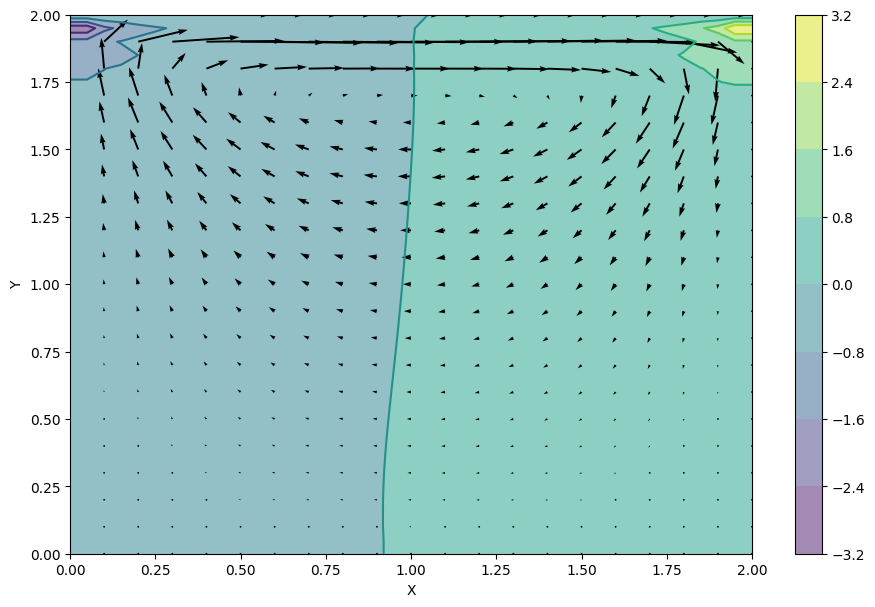

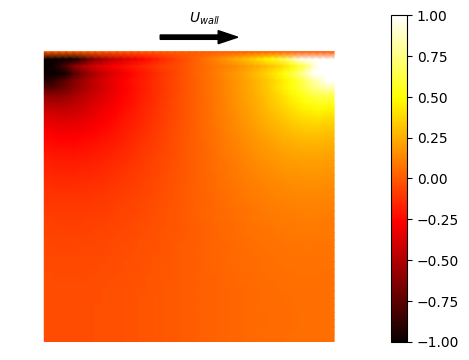

In [186]:
generate_plots(X, Y, tvm_p.numpy(), tvm_u.numpy(), tvm_v.numpy())

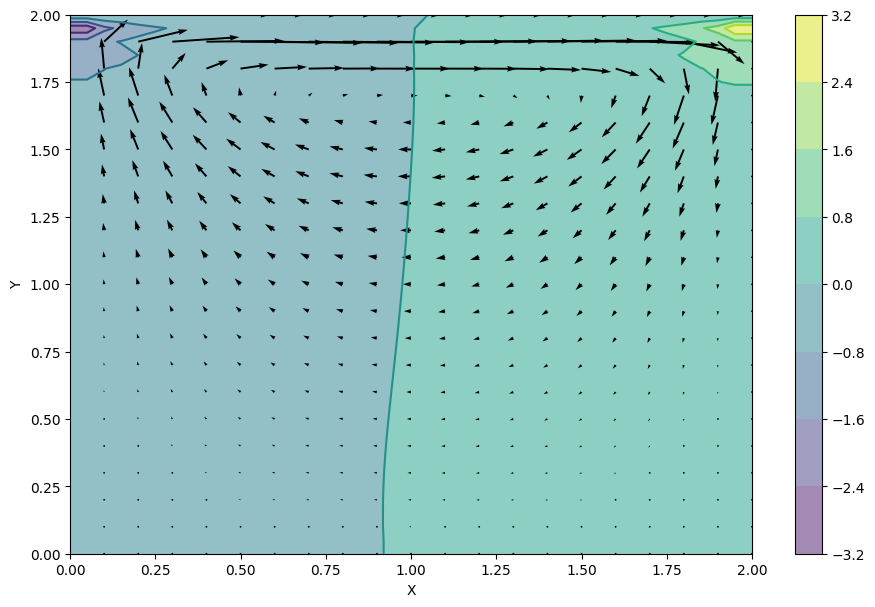

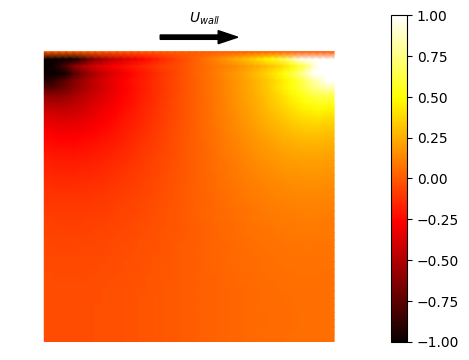

In [187]:
generate_plots(X, Y, tvm_p.numpy(), tvm_u.numpy(), tvm_v.numpy())